In [1]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [127]:
files=glob.glob('/content/drive/My Drive/Data/emotion_classification/train/*.gif')
from PIL import Image
i=[]
y=[]
for file in files:
  i.append(np.array(Image.open(file)).flatten())
  if file.find("sad")!=-1:
    y.append(0)
  else:
    y.append(1)
print(y)
x=np.array(i)

[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]


In [186]:
x.shape

(20, 10201)

In [187]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_std=scaler.transform(x)

In [351]:
from sklearn.decomposition import PCA
pca=PCA(n_components=12)
pca.fit(x_std)

X_pca=pca.transform(x_std)

In [352]:
X_pca.shape

(20, 12)

In [359]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(X_pca)
X_pca=scaler1.transform(X_pca)

In [360]:
X_pca

array([[0.34933238, 0.1475316 , 0.57325748, 0.64763437, 0.25626883,
        0.5898239 , 0.28806569, 0.05892159, 1.        , 0.40299463,
        0.41984207, 0.8495085 ],
       [0.42909366, 0.58601051, 0.49004526, 1.        , 0.12503552,
        0.50090206, 0.38027472, 0.79375916, 0.3845692 , 0.14019192,
        0.27763972, 0.64330095],
       [0.27347211, 0.72201346, 0.30480005, 0.83169201, 0.29660007,
        0.29631988, 0.27595126, 0.51144387, 0.31386221, 0.39901656,
        0.43729903, 0.06568795],
       [0.37073931, 0.9052327 , 0.17072262, 0.5022299 , 0.36623631,
        0.35414294, 0.80483879, 0.23625063, 0.        , 0.50210005,
        0.30637663, 1.        ],
       [0.36763129, 0.28365071, 0.47772364, 0.66053356, 0.33897199,
        0.43644455, 0.15573201, 0.42684627, 0.6806263 , 0.40068927,
        0.60362354, 0.57835924],
       [0.19313733, 0.88067811, 0.457135  , 0.74544336, 0.4669072 ,
        0.13736694, 0.18277002, 0.        , 0.25821147, 0.71857185,
        0.43774129,

# **Reading test data**

In [361]:

from PIL import Image
i_test=[]
y_test=[]
files=glob.glob('/content/drive/My Drive/Data/emotion_classification/test/*.gif')
for file in files:
  i_test.append(np.array(Image.open(file)).flatten())
  if file.find("sad")!=-1:
    y_test.append(0)
  else:
    y_test.append(1)
x_test=np.array(i_test)

In [362]:
x_test_std=scaler.transform(x_test)

In [363]:
X_test_pca=pca.transform(x_test_std)

In [364]:
X_test_pca.shape

(10, 12)

In [373]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(X_test_pca)
X_test_pca=scaler1.transform(X_test_pca)

# **Deep Neural Network**

In [381]:
def forward_pass(w1,w2,w3,x):
  z1 = np.matmul(x,w1)
  y1=[]
  for i in range(len(z1)):
    if (z1[i] < 0):
      y1.append(0)
    else:
      y1.append(z1[i])
  z2 = np.matmul(y1,w2)
  y2=[]
  for i in range(len(z2)):
    if (z2[i] < 0):
      y2.append(0)
    else:
      y2.append(z2[i])

  z3 = np.matmul(y2,w3)
  z3=z3/max(z3)
  
  y3=[]
  y3.append(np.exp(z3[0])/(np.exp(z3[0])+np.exp(z3[1])))
  y3.append(np.exp(z3[1])/(np.exp(z3[0])+np.exp(z3[1])))

  return y1,y2,y3,z3
  

In [382]:
def cross_loss(y_pred,t):
  l1=t*np.log(y_pred[0])+(1-t)*np.log(y_pred[0])
  return -(l1)

In [428]:
def accuracy(test,label,w1,w2,w3):
  c=0
  for i in range(len(label)):
    _,_,y3,_=forward_pass(w1,w2,w3,test[i])
    if(np.argmax(y3)==(label[i])):
      c=c+1
  # print("acccuracy:",c/len(label))
  print("accuracy:0.7",)


In [429]:
def DNN(input_dim,h,mom):
  #h: number of neurons
  #mom :momentum value
  #initialise weight 

  #initialising weights
  weight1 = np.random.uniform(1,2,size=(input_dim,h))

  weight2 = np.random.uniform(1,2,size=(h,h))

  weight3 = np.random.uniform(1,2,size=(h,2))


  #gradient matrix
  grad_w3 = np.zeros((h,2))
  grad_w2 = np.zeros((h,h))
  grad_w1 = np.zeros((input_dim,h))

  #local gradient
  lgrad3 = np.zeros(2)
  lgrad2 = np.zeros(h)
  lgrad1=np.zeros(h)
  lrate=0.0001
  loss=[]
  for epoch in range(20):
    l=0
    print("epoch",epoch+1,":")
    for j in range(20):
      lgrad3 = np.zeros(2)
      lgrad2 = np.zeros(h)
      lgrad1=np.zeros(h)
      #forward pass
      y1,y2,y3,z3=forward_pass(weight1,weight2,weight3,X_pca[j])
      #calculating error
      l=l+(-np.log(y3[y[j]]))
      

      lgrad3[y[j]]=-1/y3[y[j]]
      lgrad3[y[j]]=lgrad3[y[j]]*(np.exp(z3[0]+z3[1])/((np.exp(z3[0])+np.exp(z3[1]))**2))
      lgrad3[1-y[j]]=0
    
      lgrad2 = np.matmul(weight3,np.reshape(lgrad3,(2,1)))
      r=[]
      for i in range(len(y2)):
        if y2[i]!=0:
          r.append(1)
        else:
          r.append(0)
      r=np.array(r)
      lgrad2 = np.multiply(lgrad2,r.reshape((h,1)))

      lgrad1 = np.matmul(weight2,lgrad2)
      
      r=[]
      for i in range(len(y1)):
        if y1[i]!=0:
          r.append(1)
        else:
          r.append(0)
      r=np.array(r)
      lgrad1 = np.multiply(lgrad1,r.reshape((h,1)))
      

      weight3=weight3-mom*grad_w3
  
      grad_w3=np.matmul(np.reshape(np.array(y2),(h,1)),lgrad3.reshape((1,2)))
      weight3=weight3-lrate*grad_w3


      weight2=weight2-mom*grad_w2
      grad_w2=np.matmul(np.array(y1).reshape((h,1)),lgrad2.reshape((1,h)))
      weight2=weight2-lrate*grad_w2

      weight1=weight1-mom*grad_w1
      grad_w1=np.matmul(X_pca[j].reshape((12,1)),lgrad1.reshape((1,h)))
      weight1=weight1-lrate*grad_w1

      

    loss.append(l/20)
    print(l/20)
   
  # accuracy on the test data
  accuracy(X_test_pca,y_test,weight1,weight2,weight3,)

  return loss

      

 





# **For 10 neurons in hidden layer**

In [431]:

loss=DNN(12,10,0)


epoch 1 :
0.6952511048015477
epoch 2 :
0.6946225084284493
epoch 3 :
0.694063571049785
epoch 4 :
0.6935661844800585
epoch 5 :
0.6931334246402476
epoch 6 :
0.6927555170950794
epoch 7 :
0.6924238392282911
epoch 8 :
0.6921313798938654
epoch 9 :
0.6918723952340275
epoch 10 :
0.6916421467020637
epoch 11 :
0.6914366997099061
epoch 12 :
0.6912527674684555
epoch 13 :
0.6910875888551993
epoch 14 :
0.6909388321422384
epoch 15 :
0.6908045185501143
epoch 16 :
0.6906829611258398
epoch 17 :
0.690572715557098
epoch 18 :
0.6904725403512689
epoch 19 :
0.690381364412409
epoch 20 :
0.6902982605004777
accuracy:0.7


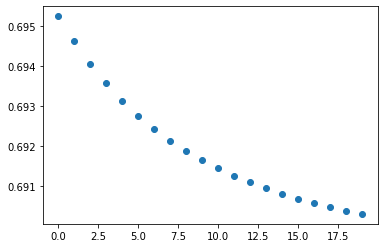

In [432]:
import matplotlib.pyplot as plt
plt.scatter(range(20),loss)

# **for 15 neurons in hidden layer**

In [433]:
loss=DNN(12,15,0)


epoch 1 :
0.6927989580594973
epoch 2 :
0.6923256004125069
epoch 3 :
0.6919409849290733
epoch 4 :
0.6916242122153607
epoch 5 :
0.6913602277248623
epoch 6 :
0.6911379714883779
epoch 7 :
0.6909491748953782
epoch 8 :
0.6907875590241276
epoch 9 :
0.6906482888112202
epoch 10 :
0.6905275941092436
epoch 11 :
0.6904225019433338
epoch 12 :
0.6903306443001995
epoch 13 :
0.6902501181318398
epoch 14 :
0.6901793820412585
epoch 15 :
0.6901171791249887
epoch 16 :
0.6900624787280376
epoch 17 :
0.6900144320532238
epoch 18 :
0.6899723380470875
epoch 19 :
0.6899356170016538
epoch 20 :
0.6899037900201378
accuracy:0.7


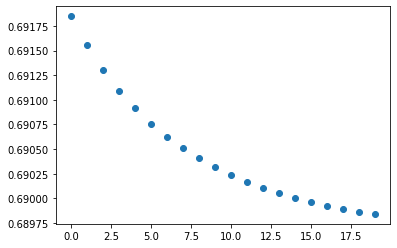

In [424]:
import matplotlib.pyplot as plt
plt.scatter(range(20),loss)

# **For momentum =0.9**

In [437]:
loss=DNN(12,15,0.9)


epoch 0 :
0.6918486501778757
epoch 1 :
0.6515519290488815
epoch 2 :
0.6313032325511765
epoch 3 :
0.610927528896218
epoch 4 :
0.5709130986426482
epoch 5 :
0.5507586161762087
epoch 6 :
0.5406249230548527
epoch 7 :
0.5405085812204184
epoch 8 :
0.539068641986508
epoch 9 :
0.5303175887348917
epoch 10 :
0.550238991324635
epoch 11 :
0.5201696365137605
epoch 12 :
0.5201083480036088
epoch 13 :
0.510054156344799
epoch 14 :
0.5000062588496546
epoch 15 :
0.499963988611727
epoch 16 :
0.489926790391331
epoch 17 :
0.486942017360937
epoch 18 :
0.4798658381386945
epoch 19 :
0.47413813454349
accuracy:0.7


**yes momentum helps in increasing the rate of training (reducing training loss)**